## PROJECT OVERVIEW

I have chosen a dataset from Kaggle that contains measurements monetary bills. The dataset cointains 1500 rows and 7 columns. The data contains 1000 genuine bills and 500 fake bills.

The columns are:
- is_genuine (True or False representing whether the bill is real or fake)
- diagonal (the bills diagonal measurement in mm)
- height_left (the height of left side of the bill in mm)
- height_right (the height of the right side of the bill in mm)
- margin_low (the bottom margin in mm)
- margin_up (the upper_margin in mm)
- length (the total length in mm)

The link to the Kaggle dataset is :
https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills/data

The goal of the project is to build a classification model that can correctly predict whether a bill is real or fake. In doing so, I want to compare supervised and unsupervised techniques to determine if there is a significant performance difference between the different methods. Below I am going to implement the following machine learning techniques and evaluate their performance:

Supervised Learning
- Logistic Regression
- K-Nearest Neighbors

Unsupervised Learning:
- K-Means Clustering
- Agglomerative Clustering
- DBSCAN

#### IMPORT LIBRARIES

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer, silhouette_score

from scipy.stats import mode


#### IMPORT DATA

In [118]:
# Load the data and separate by ;
data = pd.read_csv('data/fake_bills.csv', sep=';')

# View data
data.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### DATA PREPROCESSING & CLEANING

In [119]:
# Check for duplicates
duplicates = data.duplicated().sum()
duplicates

0

In [120]:
# Check that no filler values are present
data.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [121]:
# Check data types
data.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [122]:
# Check for missing values
missing = data.isnull().sum()
missing

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In the below cell I use KNN Imputer to impute the 37 missing values that we have found.

In [123]:
# Use KNN to impute missing values

# Create the imputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
data_imputed = imputer.fit_transform(data)

# Convert the data back to a DataFrame
data_imputed = pd.DataFrame(data_imputed, columns=data.columns)

In [124]:
# Recheck for missing values
missing_imputed = data_imputed.isnull().sum()
missing_imputed

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Next, it appeared that the original data was ordered by the value in the is_genuine column. Because of this, I want to shuffle the data before splitting to make sure both splits are representative of the whole.

In [125]:
# Shuffle the data
data = data_imputed.sample(frac=1, random_state=42).reset_index(drop=True)

After performing my initial model building, I noticed that the majority of the models were highly accurate (above 98% accuracy). In an attempt to make this project more challenging and potentially representative of data found in the real world, I have decided to add randomly distributed error terms to each of the feature columns. Here I use a random number generator with a mean of 0 and a variance equal to the existing standard deviation for the respective column.

In [126]:
# Add normal errors
data['diagonal'] = data['diagonal'] + np.random.normal(0, 0.30, len(data))
data['height_left'] = data['height_left'] + np.random.normal(0, 0.29, len(data))
data['height_right'] = data['height_right'] + np.random.normal(0, 0.32, len(data))
data['margin_low'] = data['margin_low'] + np.random.normal(0, 0.65, len(data))
data['margin_up'] = data['margin_up'] + np.random.normal(0, 0.23, len(data))
data['length'] = data['length'] + np.random.normal(0, 0.87, len(data))

In [127]:
data.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.666667,171.970475,104.025049,103.914882,4.507338,3.150559,112.699799
std,0.471562,0.427228,0.398172,0.461914,0.946538,0.318442,1.218039
min,0.000000,170.422995,102.531354,102.140297,1.967673,2.185109,108.660334
25%,0.000000,171.662840,103.763808,103.607275,3.844861,2.934196,111.916115
50%,1.000000,171.976785,104.035247,103.913515,4.424157,3.143583,112.768657
75%,1.000000,172.269623,104.301364,104.224109,5.101859,3.359741,113.558285
max,1.000000,173.177150,105.312569,105.321960,8.233345,4.149554,115.747130


We can now see that more variance has been introduced to the feature columns, making the task of modeling more difficult.

In [128]:
# Split the response variable from the predictors
X = data.drop(columns='is_genuine')
y = data['is_genuine']

# Check the shape of the data
X.shape, y.shape

((1500, 6), (1500,))

In [129]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

I also wanted to test the effects of scaling the data to see how this would impact model performance. Below I create a scaled version of the data that will be used in some of the model building.

In [130]:
# Create a standardized version of the features
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Convert the data back to a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

#### EXPLORATORY DATA ANALYSIS (EDA)

As a reminder from, the data set contains the following columns:
- is_genuine (True or False representing whether the bill is real or fake)
- diagonal (the bills diagonal measurement in mm)
- height_left (the height of left side of the bill in mm)
- height_right (the height of the right side of the bill in mm)
- margin_low (the bottom margin in mm)
- margin_up (the upper_margin in mm)
- length (the total length in mm)

First I want to plot all features to get an idea of how they are distributed.

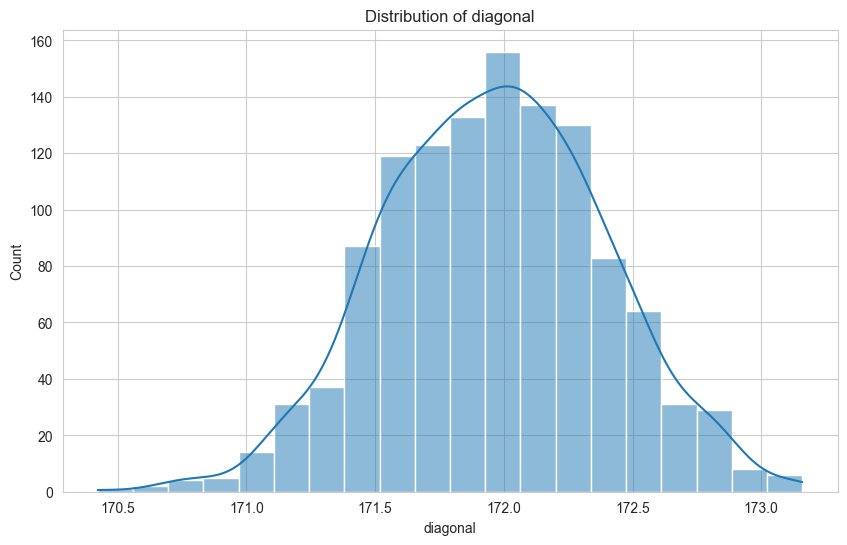

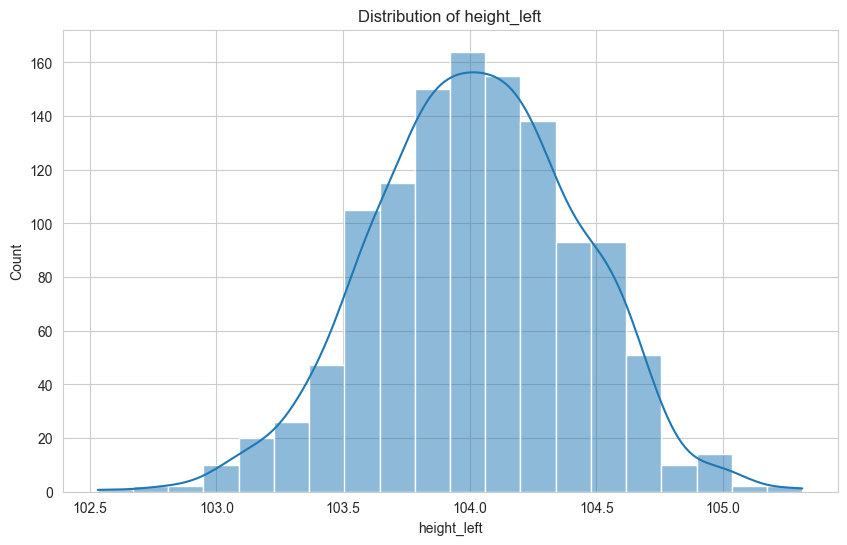

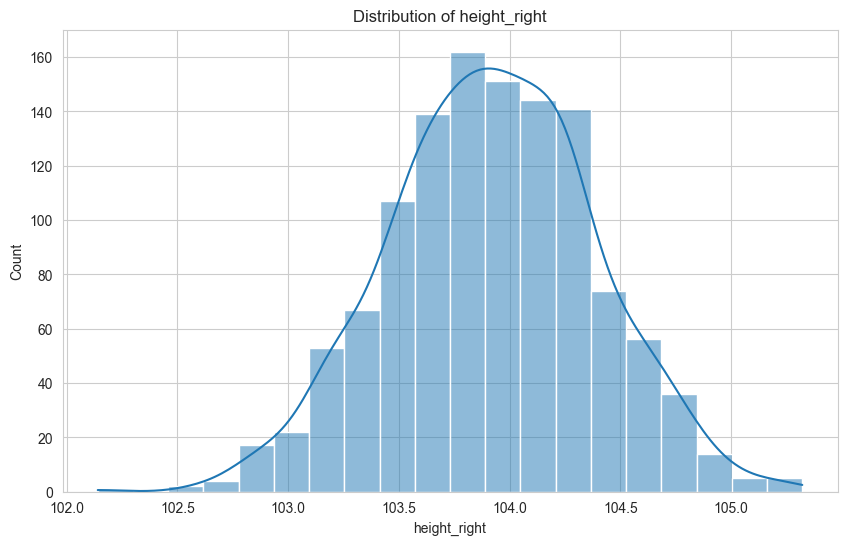

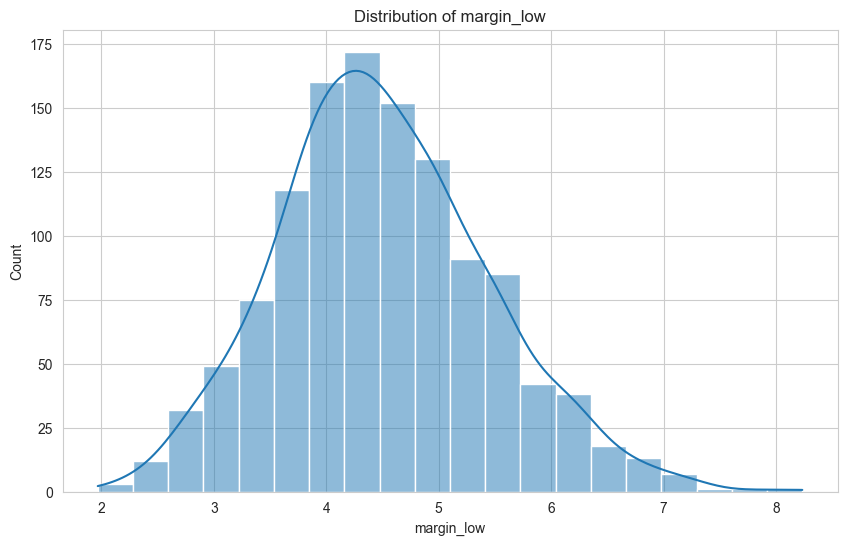

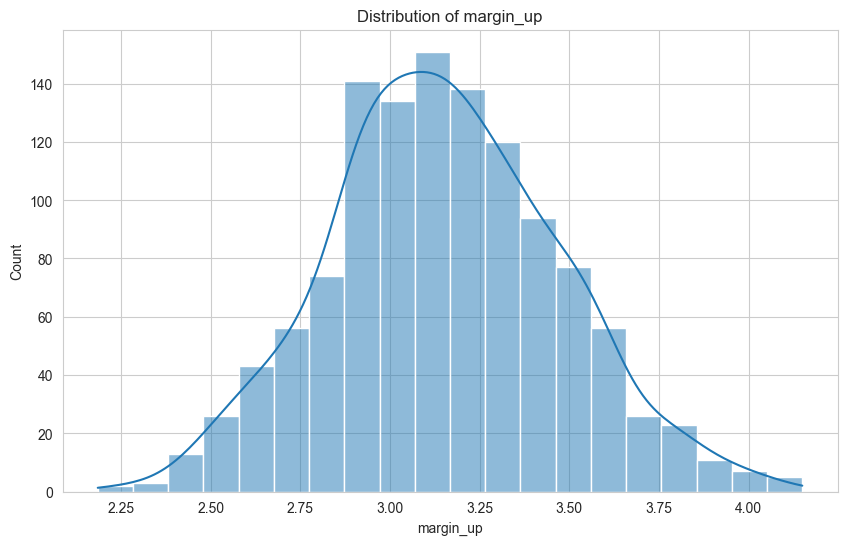

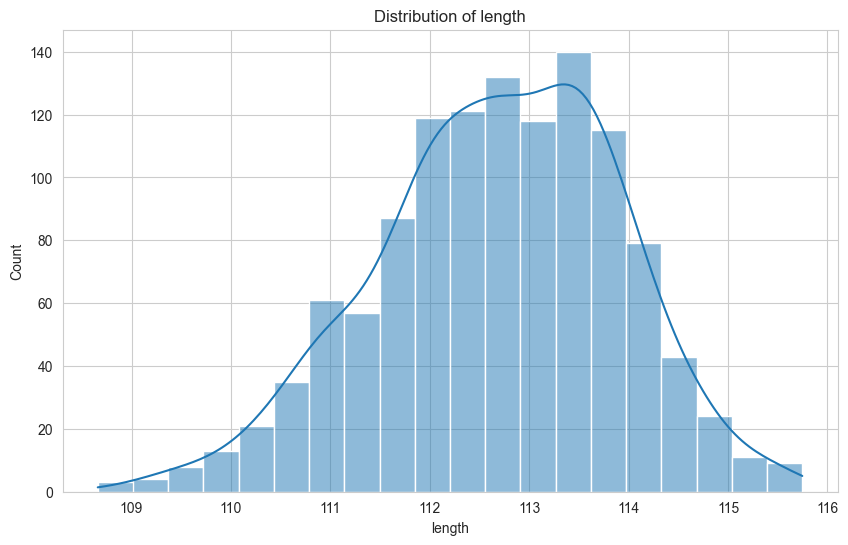

In [131]:
# Visualize distributions of the features
for col in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(X_train[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

In the above distributions, there does not seem to be anything that would easily be identified as something representative of fake bills such as two seperate peaks.

Next, I wanted to create box plots for each feature to visualize outliers.

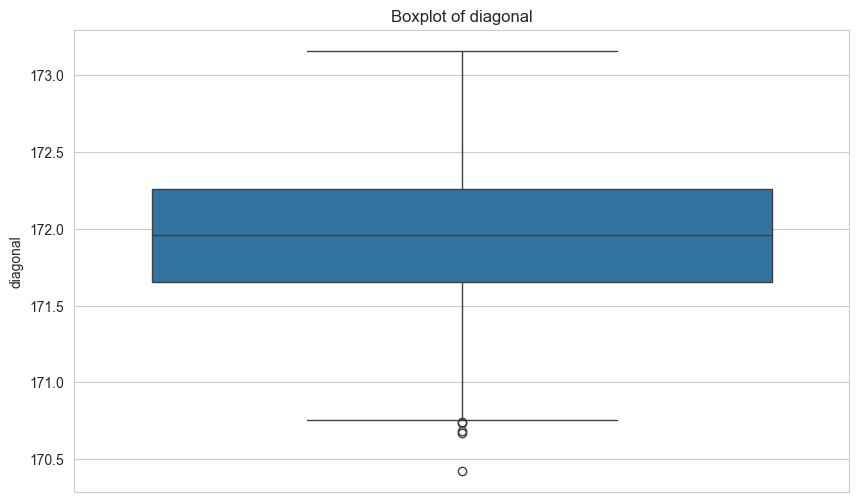

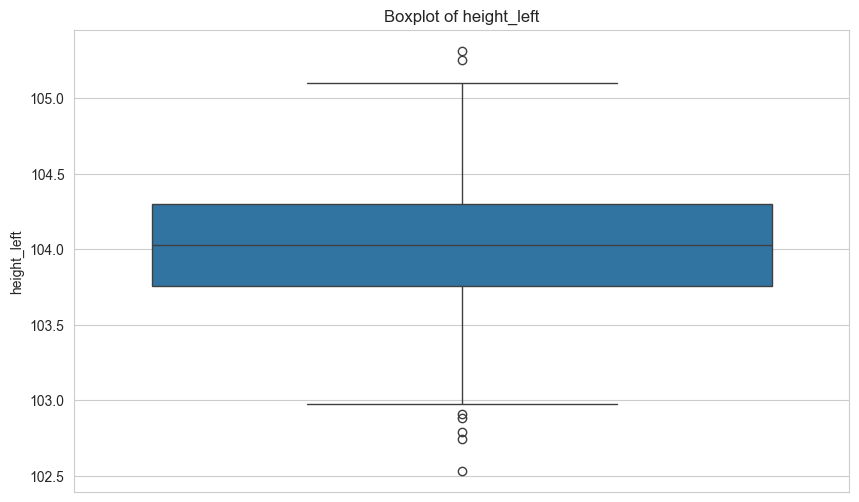

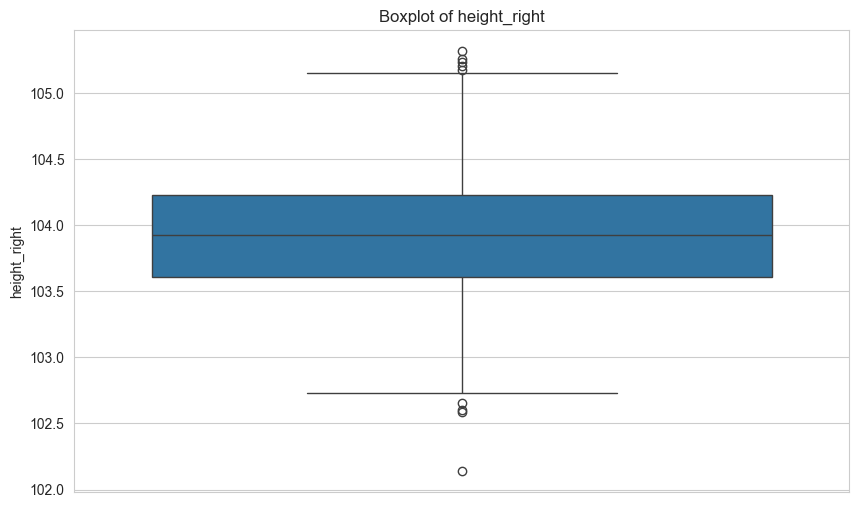

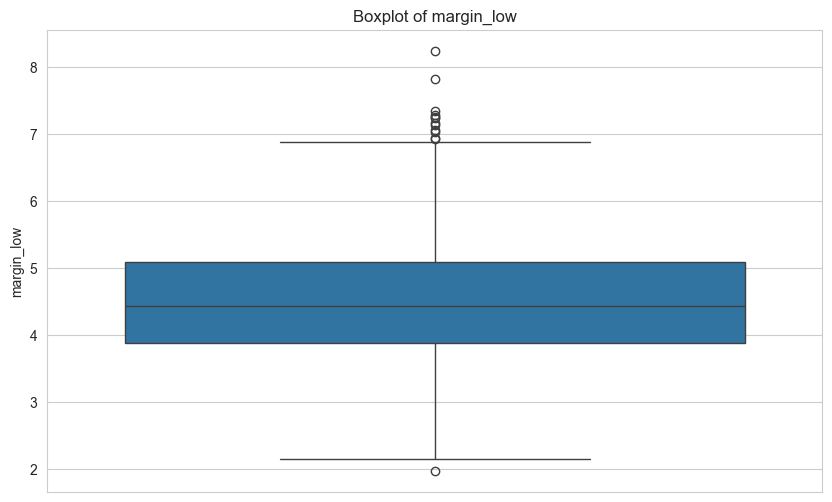

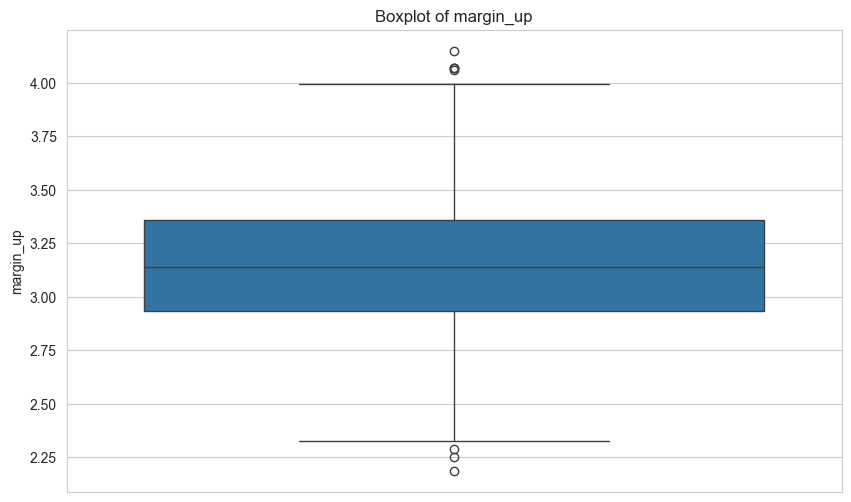

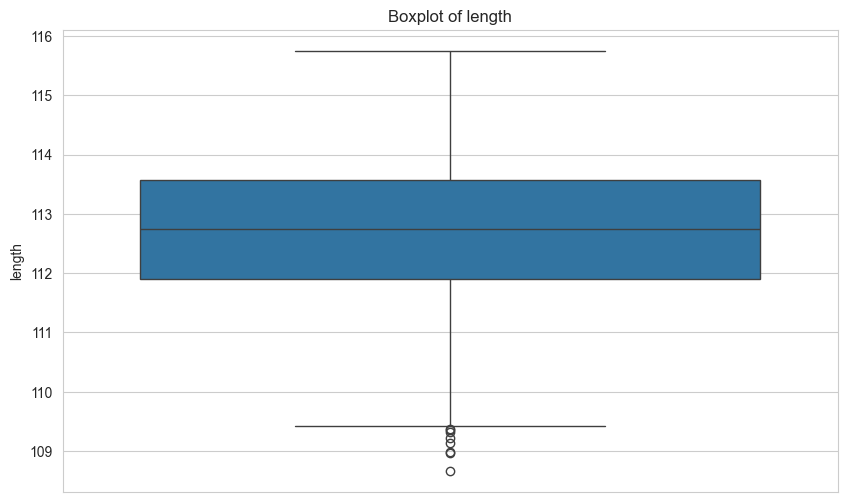

In [132]:
# Create boxplots of the features
for col in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=X_train[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

The number of outliers is not large and I believe that these outliers may help identify their respective bills. Becasue of this, I have chosen to keep the outliers in the data.

Next, I want to see how the features correlate with each other to see if there are any strong connections that I need to be aware of.

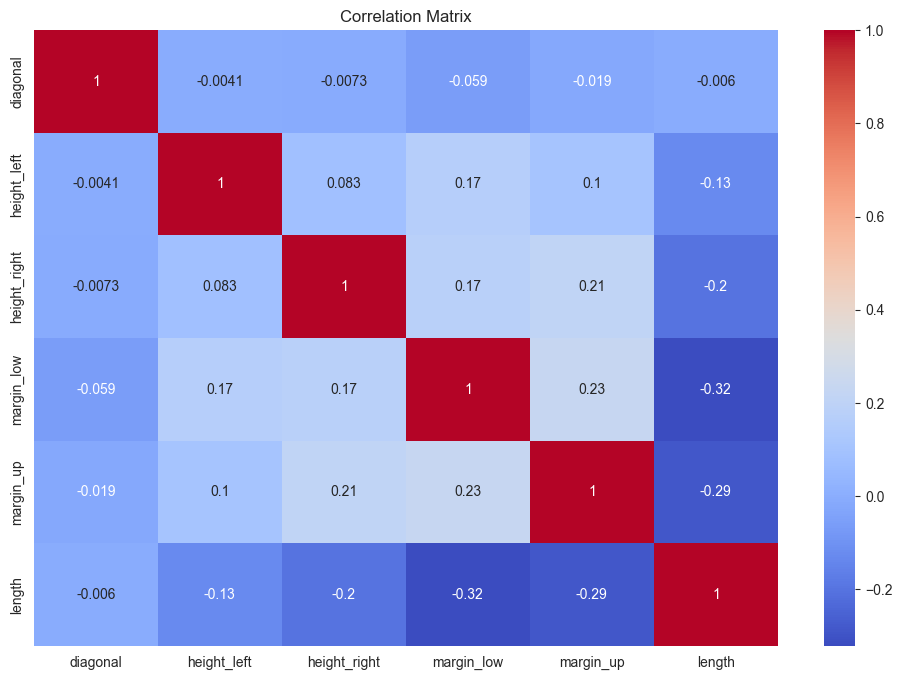

In [133]:
# Create a correlation matrix
corr = X_train.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The correlation matrix does not show any strong correlation between features.

Next I wanted to plot the distribution of features while separating for whether the bill is genuine. This will visualize some of the differentiating factors that are models will likely draw on to classify the bills.

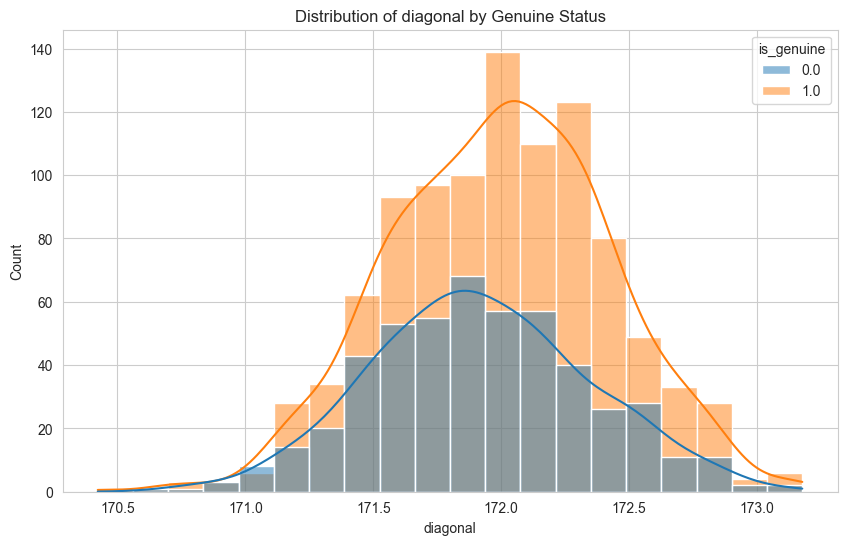

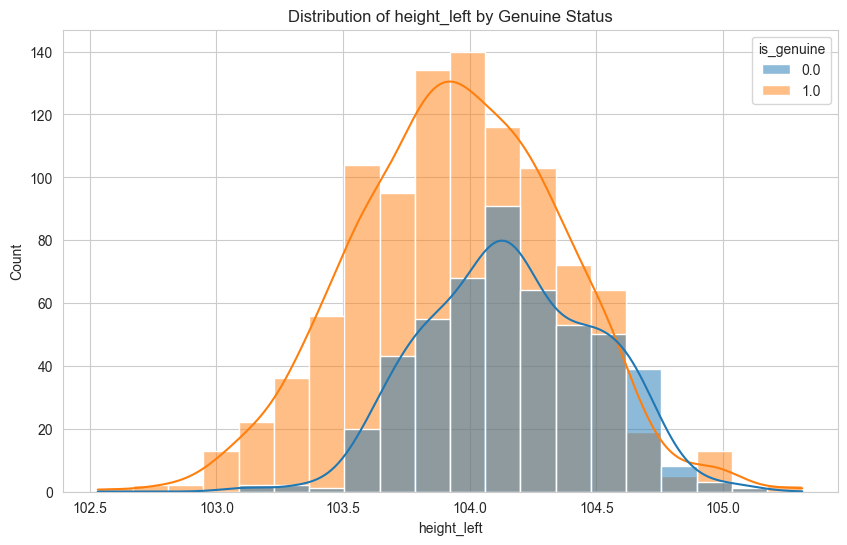

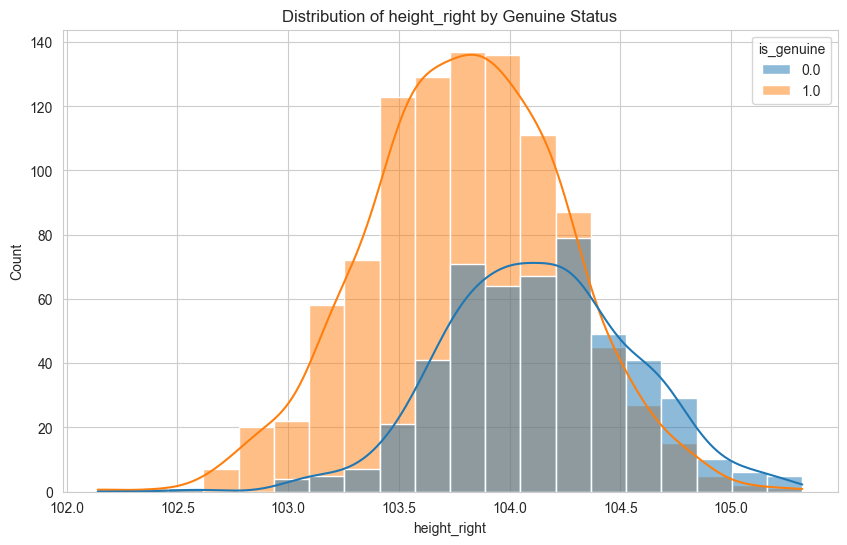

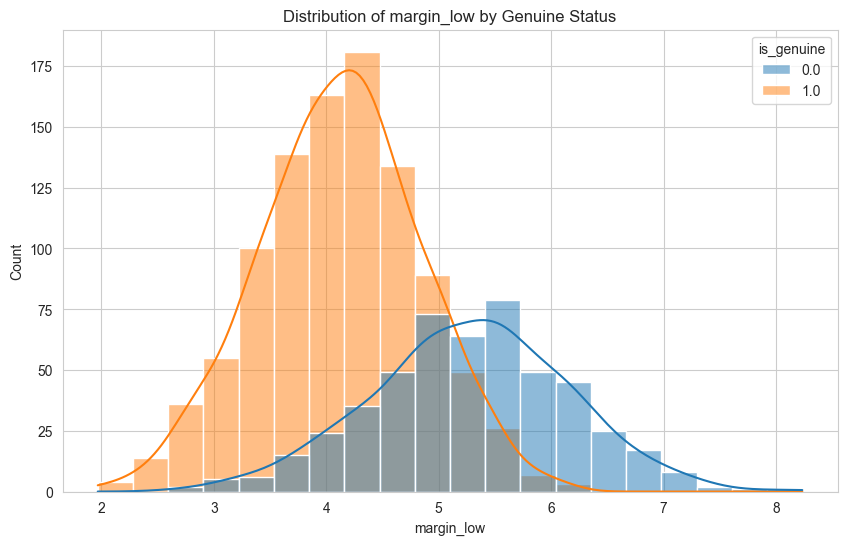

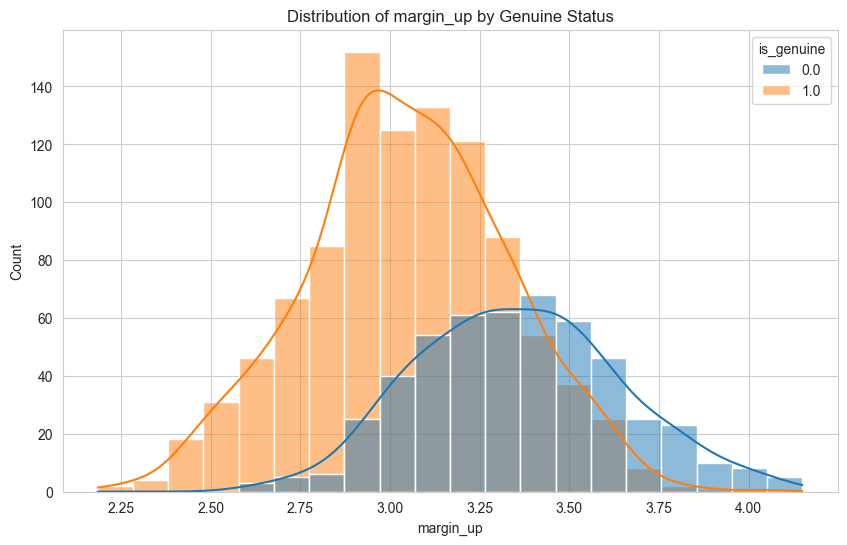

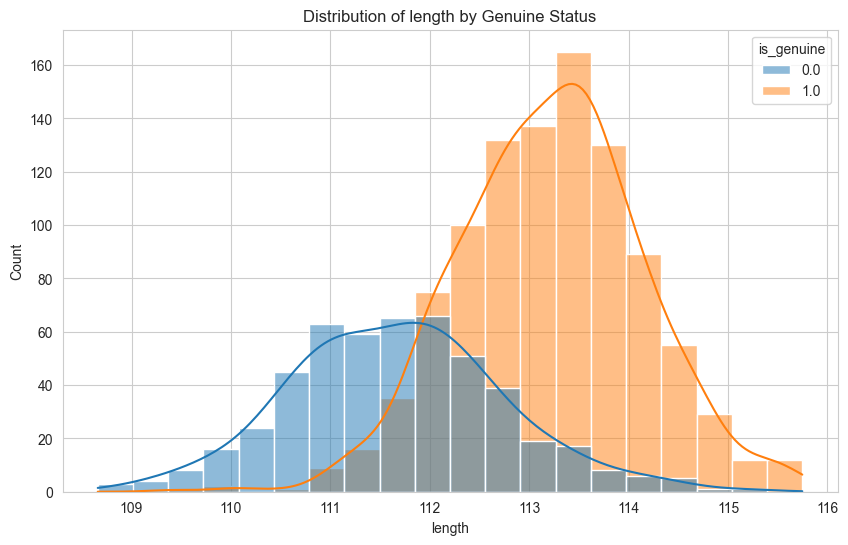

In [134]:
# Plot distributions of feature by genuine status
for col in X_train.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data, x=col, hue='is_genuine', kde=True, bins=20)
    plt.title(f'Distribution of {col} by Genuine Status')
    plt.show()

From the above plots, we can see differences in the distributions for all features except for diagonal. These differences will likely be key in successfully classifying the bills.

Lastly, I wanted to create a pairplot to visualize some of the differences that are shown above and start to visualize what the clustering may look like.

<Figure size 1200x800 with 0 Axes>

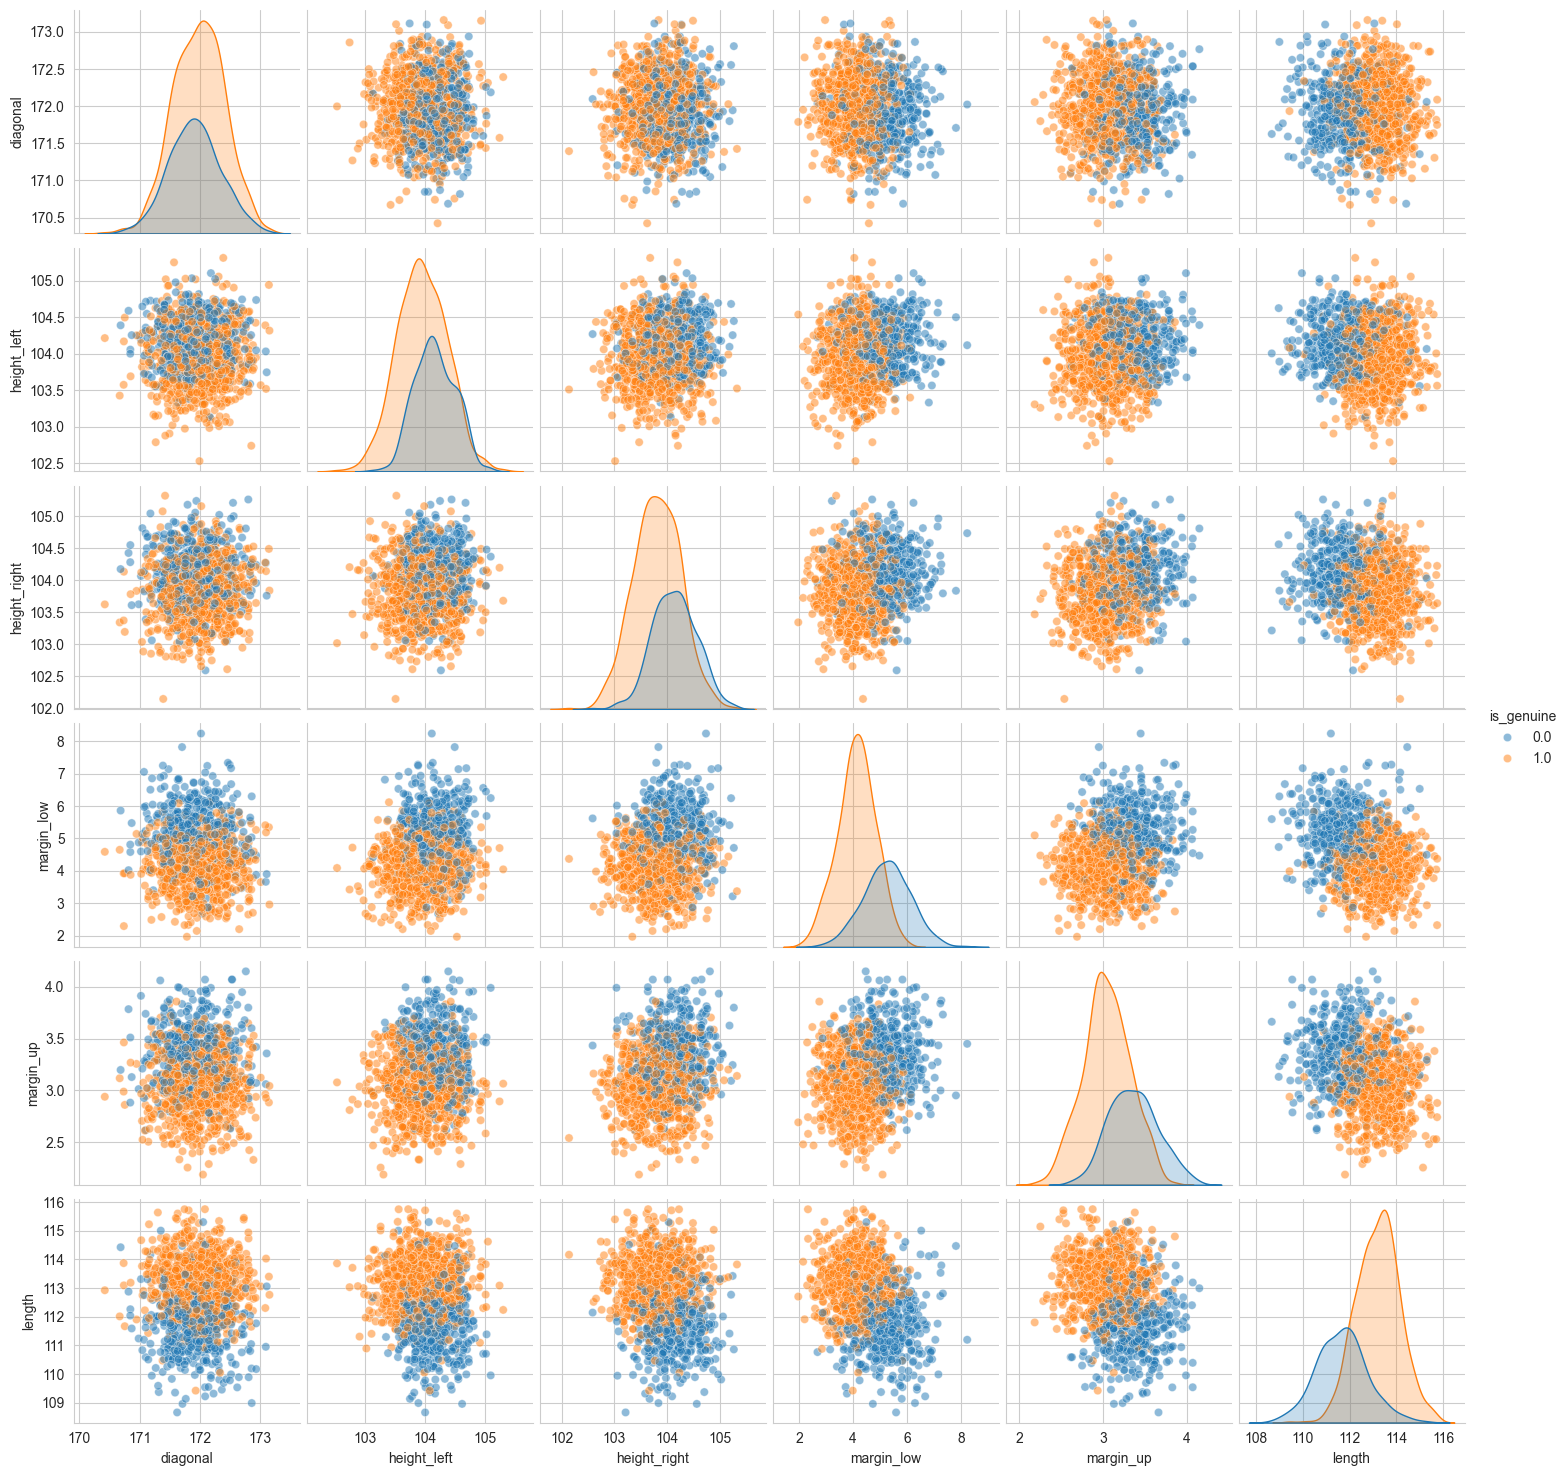

In [135]:
# Create a pairplot
data_pairplot = X_train.copy()
data_pairplot['is_genuine'] = y_train
plt.figure(figsize=(12, 8))
sns.pairplot(data_pairplot, hue='is_genuine', plot_kws={'alpha': 0.5})

plt.show()

#### DIMENSIONALITY REDUCTION USING PCA

I wanted to attempt to use PCA to reduce the number of features. Unfortunately, as shown in the below plot, this technique is not effective for this data which makes sense given that there are not many features and they are not highly correlated.

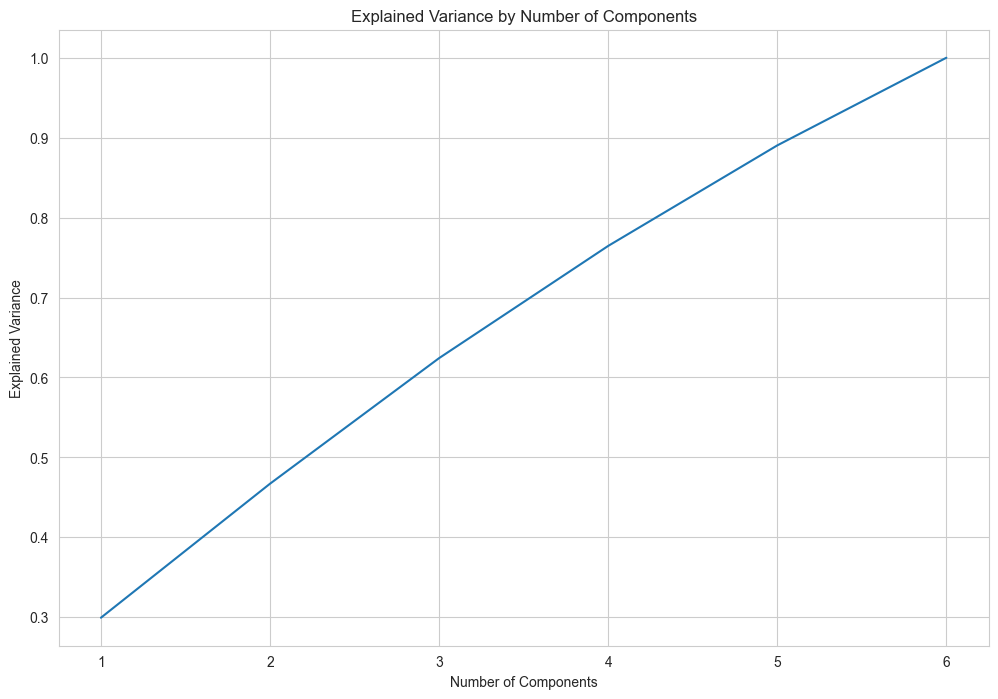

In [136]:
# Create a PCA object
pca = PCA()

# Fit the PCA object
pca.fit(X_train_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.show()


#### MODEL BUILDING

I create a data frame to store the model results. As evaluation metrics I included the test and train accuracy of each model. Because the classes (is_genuine, TRUE or FALSE) are not balanced, I also wanted to add the AUC-ROC metric to further capture how the model is performing.

After fitting and evaluating every model, I store the above metrics into the dataframe which will be evaluated at the end.

In [137]:
# Create dataframe to store model results
model_results = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy', 'AUC-ROC'])


##### Supervised Learning Models:

First I begin with supervised models which means these models can use the 'is_genuine' column when training. I would expect these models to perform better than the unsupervised models becuase of this advantage. For both the models, I create a model using the standard data and then a model using the scaled data to compare performance.

In [138]:
# Logistic Regression Model with Non-Scaled Data

# Create a logistic regression object
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train, y_train)

# Calculate the training and testing accuracy
train_accuracy = log_reg.score(X_train, y_train)
test_accuracy = log_reg.score(X_test, y_test)

# Calculate AUC-ROC
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Store as new_row
new_row = {'Model': 'Logistic Regression (Non-Scaled)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

/var/folders/hp/1v_5y_0j4vddb6txj06yjs_40000gn/T/ipykernel_25840/2272667500.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, pd.DataFrame([new_row])])


In [139]:
# Logistic Regression Model with Scaled Data

# Fit the model
log_reg.fit(X_train_scaled, y_train)

# Calculate the training and testing accuracy
train_accuracy = log_reg.score(X_train_scaled, y_train)
test_accuracy = log_reg.score(scaler.transform(X_test), y_test)

# Calculate AUC-ROC
y_pred_proba = log_reg.predict_proba(scaler.transform(X_test))[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Store as new_row
new_row = {'Model': 'Logistic Regression (Scaled)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

/Users/jacob/PycharmProjects/Unsup Learning/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2728: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/jacob/PycharmProjects/Unsup Learning/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2728: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [140]:
# KNN Model with Non-Scaled Data

# Create a KNN object
knn = KNeighborsClassifier()

# Fit the model
knn.fit(X_train, y_train)

# Calculate the training and testing accuracy
train_accuracy = knn.score(X_train, y_train)
test_accuracy = knn.score(X_test, y_test)

# Calculate AUC-ROC
y_pred_proba = knn.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Store as new_row
new_row = {'Model': 'KNN (Non-Scaled)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

In [141]:
# KNN Model with Scaled Data

# Fit the model
knn.fit(X_train_scaled, y_train)

# Calculate the training and testing accuracy
train_accuracy = knn.score(X_train_scaled, y_train)
test_accuracy = knn.score(scaler.transform(X_test), y_test)

# Calculate AUC-ROC
y_pred_proba = knn.predict_proba(scaler.transform(X_test))[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Store as new_row
new_row = {'Model': 'KNN (Scaled)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

/Users/jacob/PycharmProjects/Unsup Learning/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2728: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/Users/jacob/PycharmProjects/Unsup Learning/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2728: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


##### Unsupervised Learning Models:

Now I move to unsupervised learning models. These models do not have access to the 'is_genuine' column when training. I do use the 'is_genuine' column when testing the models predictions and creating the metrics defined at the start of the model building section.

In [142]:
# K Means Clustering Model

# Create a KMeans object
kmeans = KMeans(n_clusters=2)

# Fit the model
kmeans.fit(X_train)

# Calculate the training accuracy by mapping predicted clusters to true labels
train_labels = []
for cluster in np.unique(kmeans.labels_):
    true_labels = y_train[kmeans.labels_ == cluster]

    # Ensure that there are true labels and handle edge cases
    if len(true_labels) > 0:
        # Apply mode with keepdims=True to handle version differences
        mode_result = mode(true_labels, keepdims=True)
        train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
    else:
        train_labels.append(None)  # Handle the case if there are no true labels for this cluster

# Map the entire kmeans.labels_ to the most common label for each cluster
train_pred_mapped = np.array([train_labels[label] for label in kmeans.labels_])

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_pred_mapped)

# Predict clusters for the test data
y_pred = kmeans.predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(kmeans.labels_):
    true_labels = np.array(y_train[kmeans.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'KMeans', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

Next, I perform hyper parameter tuning for the K-Means model to maximize the accuracy.

In [143]:
# Hyperparameter Tuning for K Means Clustering Model


# Create a parameter grid
param_grid = {'n_clusters': [2],
                'init': ['k-means++', 'random'],
                'n_init': [10, 20, 30, 40, 50],
                'max_iter': [100, 200, 300, 400, 500]}

# Create a grid search object
grid_search = GridSearchCV(kmeans, param_grid, cv=5)
grid_search.fit(X_train)

# Calculate the training accuracy
train_accuracy = np.mean(grid_search.best_estimator_.labels_ == y_train)

# Predict clusters for the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(grid_search.best_estimator_.labels_):
    true_labels = np.array(y_train[grid_search.best_estimator_.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'KMeans (Tuned)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])


Now, I wanted to test a different a type of clustering. I first start with a model where only the number of clusters is specified. Then I perform a manual grid serach to find the best hyperparameters and then recalculate the evaluation metrics using those provided parameters.

In [144]:
# Agglomerative Clustering Model

# Create an Agglomerative Clustering object
agg_clustering = AgglomerativeClustering(n_clusters=2)

# Fit the model
agg_clustering.fit(X_train)

# Calculate the training accuracy by mapping predicted clusters to true labels
train_labels = []
for cluster in np.unique(agg_clustering.labels_):
    true_labels = y_train[agg_clustering.labels_ == cluster]

    # Ensure that there are true labels and handle edge cases
    if len(true_labels) > 0:
        # Apply mode with keepdims=True to handle version differences
        mode_result = mode(true_labels, keepdims=True)
        train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
    else:
        train_labels.append(None)  # Handle the case if there are no true labels for this cluster

# Map the entire agg_clustering.labels_ to the most common label for each cluster
train_pred_mapped = np.array([train_labels[label] for label in agg_clustering.labels_])

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_pred_mapped)

# Predict clusters for the test data
y_pred = agg_clustering.fit_predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(agg_clustering.labels_):
    true_labels = np.array(y_test[agg_clustering.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'Agglomerative Clustering', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

In [145]:
# Hyperparameter Tuning for Agglomerative Clustering Model

# Define the model
agg_clustering = AgglomerativeClustering()

# Parameters to test
param_grid = {'n_clusters': [2],
                'linkage': ['ward', 'complete', 'average', 'single'],
                'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']}

# Manually loop through the parameter grid
best_score = -np.inf
best_params = {}

for n_clusters in param_grid['n_clusters']:
    for linkage in param_grid['linkage']:
        for metric in param_grid['metric']:
            # If the linkage is ward, only the euclidean metric is allowed
            if linkage == 'ward' and metric != 'euclidean':
                continue
            # Create the model
            model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, metric=metric)

            # Fit the model
            model.fit(X_train)

            # Calculate the training accuracy by mapping predicted clusters to true labels
            train_labels = []
            for cluster in np.unique(model.labels_):  # Use model.labels_ instead of agg_clustering.labels_
                true_labels = y_train[model.labels_ == cluster]

                # Ensure that there are true labels and handle edge cases
                if len(true_labels) > 0:
                    # Apply mode with keepdims=True to handle version differences
                    mode_result = mode(true_labels, keepdims=True)
                    train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
                else:
                    train_labels.append(None)  # Handle the case if there are no true labels for this cluster

            # Map the entire model.labels_ to the most common label for each cluster
            train_pred_mapped = np.array([train_labels[label] for label in model.labels_])

            # Calculate the training accuracy
            train_accuracy = accuracy_score(y_train, train_pred_mapped)

            # Update the best_score and best_params if applicable
            if train_accuracy > best_score:
                best_score = train_accuracy
                best_params = {'n_clusters': n_clusters, 'linkage': linkage, 'metric': metric}

print(best_params)

{'n_clusters': 2, 'linkage': 'ward', 'metric': 'euclidean'}


In [146]:
# Agglomerative Clustering Model with Best Parameters

# Create an Agglomerative Clustering object
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage= best_params['linkage'], metric=best_params['metric'])

# Fit the model
agg_clustering.fit(X_train)

# Calculate the training accuracy by mapping predicted clusters to true labels
train_labels = []
for cluster in np.unique(agg_clustering.labels_):
    true_labels = y_train[agg_clustering.labels_ == cluster]

    # Ensure that there are true labels and handle edge cases
    if len(true_labels) > 0:
        # Apply mode with keepdims=True to handle version differences
        mode_result = mode(true_labels, keepdims=True)
        train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
    else:
        train_labels.append(None)  # Handle the case if there are no true labels for this cluster

# Map the entire agg_clustering.labels_ to the most common label for each cluster
train_pred_mapped = np.array([train_labels[label] for label in agg_clustering.labels_])

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_pred_mapped)

# Predict clusters for the test data
y_pred = agg_clustering.fit_predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(agg_clustering.labels_):
    true_labels = np.array(y_test[agg_clustering.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'Agglomerative Clustering (Tuned)', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

Lastly, I wanted to try to implement a DBSCAN model which I had never used before. I follow the same process as above, first fitting a model with no hyperparameters specified other than the number of clusters. Then I perform a implement a manual grid search to identify the best hyperparameters and calculate the evalution metrics using those parameters.

In [155]:
# DBSCAN Model

# Create a DBSCAN object
dbscan = DBSCAN()

# Fit the model
dbscan.fit(X_train)

# Calculate the training accuracy by mapping predicted clusters to true labels
train_labels = []
for cluster in np.unique(dbscan.labels_):
    if cluster == -1:  # Handle the case if the cluster is noise
        continue
    true_labels = y_train[dbscan.labels_ == cluster]

    # Ensure that there are true labels and handle edge cases
    if len(true_labels) > 0:
        # Apply mode with keepdims=True to handle version differences
        mode_result = mode(true_labels, keepdims=True)
        train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
    else:
        train_labels.append(None)  # Handle the case if there are no true labels

# Map the entire dbscan.labels_ to the most common label for each cluster
train_pred_mapped = np.array([train_labels[label] for label in dbscan.labels_])

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_pred_mapped)

# Predict clusters for the test data
y_pred = dbscan.fit_predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(dbscan.labels_):
    true_labels = np.array(y_test[dbscan.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'DBSCAN', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

In [156]:
# Hyperparameter Tuning for DBSCAN Model

# Define the model
dbscan = DBSCAN()

# Parameters to test
param_grid = {'eps': [0.1, 0.5, 1.0, 1.5, 2.0],
                'min_samples': [5, 10, 15, 20, 25],
                'metric': ['euclidean', 'manhattan'],
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}


# Manually loop through the parameter grid
best_score = -np.inf
best_params = {}

for eps in param_grid['eps']:
    for min_samples in param_grid['min_samples']:
        for metric in param_grid['metric']:
            for algorithm in param_grid['algorithm']:
                # Create the model
                model = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm)

                # Fit the model
                model.fit(X_train)

                # Calculate the training accuracy by mapping predicted clusters to true labels
                train_labels = []
                for cluster in np.unique(model.labels_):  # Use model.labels_ instead of dbscan.labels_
                    if cluster == -1:  # Handle the case if the cluster is noise
                        continue
                    true_labels = y_train[model.labels_ == cluster]

                    # Ensure that there are true labels and handle edge cases
                    if len(true_labels) > 0:
                        # Apply mode with keepdims=True to handle version differences
                        mode_result = mode(true_labels, keepdims=True)
                        # Avoid appending None if there are no mode results
                        if mode_result.mode.size > 0:
                            train_labels.append(mode_result.mode[0])
                    # If there are no valid true labels for the cluster, don't append None
                # Map the entire model.labels_ to the most common label for each cluster
                train_pred_mapped = np.array([train_labels[label] if label != -1 else None for label in model.labels_])

                # Skip accuracy calculation if any train_pred_mapped is None
                if None not in train_pred_mapped:
                    # Calculate the training accuracy
                    train_accuracy = accuracy_score(y_train, train_pred_mapped)

                    # Update the best_score and best_params if applicable
                    if train_accuracy > best_score:
                        best_score = train_accuracy
                        best_params = {'eps': eps, 'min_samples': min_samples, 'metric': metric, 'algorithm': algorithm}

print(best_params)

{'eps': 1.5, 'min_samples': 5, 'metric': 'euclidean', 'algorithm': 'auto'}


In [157]:
# DBSCAN Model with Best Parameters

# Create a DBSCAN object
dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'], metric=best_params['metric'], algorithm=best_params['algorithm'])

# Fit the model
dbscan.fit(X_train)

# Calculate the training accuracy by mapping predicted clusters to true labels
train_labels = []
for cluster in np.unique(dbscan.labels_):
    if cluster == -1:  # Handle the case if the cluster is noise
        continue
    true_labels = y_train[dbscan.labels_ == cluster]

    # Ensure that there are true labels and handle edge cases
    if len(true_labels) > 0:
        # Apply mode with keepdims=True to handle version differences
        mode_result = mode(true_labels, keepdims=True)
        train_labels.append(mode_result.mode[0] if mode_result.mode.size > 0 else None)
    else:
        train_labels.append(None)  # Handle the case if there are no true labels

# Map the entire dbscan.labels_ to the most common label for each cluster
train_pred_mapped = np.array([train_labels[label] for label in dbscan.labels_])

# Calculate the training accuracy
train_accuracy = accuracy_score(y_train, train_pred_mapped)

# Predict clusters for the test data
y_pred = dbscan.fit_predict(X_test)

# Map the predicted clusters to the true labels
cluster_to_label = {}
for cluster in np.unique(dbscan.labels_):
    true_labels = np.array(y_test[dbscan.labels_ == cluster])  # Ensure it's a NumPy array
    cluster_to_label[cluster] = mode(true_labels, keepdims=True).mode[0] if len(true_labels) > 0 else None

# Map the predicted clusters to the true labels
y_pred_mapped = np.array([cluster_to_label[cluster] for cluster in y_pred])

# Calculate the testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_mapped)

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mapped)

# Store as new_row
new_row = {'Model': 'DBSCAN', 'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy, 'AUC-ROC': auc_roc}

# Add new_row to model_results
model_results = pd.concat([model_results, pd.DataFrame([new_row])])

#### MODEL EVALUATION

In [152]:
# View the model results
model_results

,Model,Train Accuracy,Test Accuracy,AUC-ROC
0,Logistic Regression (Non-Scaled),0.922500,0.916667,0.970265
0,Logistic Regression (Scaled),0.923333,0.920000,0.973244
0,KNN (Non-Scaled),0.933333,0.910000,0.938702
0,KNN (Scaled),0.933333,0.910000,0.937448
0,KMeans,0.848333,0.860000,0.853574
0,KMeans (Tuned),0.835833,0.853333,0.851798
0,Agglomerative Clustering,0.889167,0.886667,0.875836
0,Agglomerative Clustering (Tuned),0.889167,0.886667,0.875836
0,DBSCAN,0.672500,0.693333,0.500000
0,DBSCAN,0.660000,0.693333,0.500000


In [153]:
print('Notebook has been run successfully')

Notebook has been run successfully


In [ ]:
# Run above this cell to ensure all cells have been run

#### CONCLUSION

When looking at the model evaluation table above, I was generally surprised. I think a lot of times we get caught up in wanting to build the most complex models that have a ton of hyperparameters. Much to my surprise, the best-performing model was also the most simple. Logistic regression had the best performance metrics. The logistic regression model that used the scaled data had a very slight performance in the AUC-ROC score over the version that used the normal data. This benefit was so subtle that either model would be suitable but the model using the non-scaled data is slightly easier to interpret.

The unsupervised algorithms performed well but could not fully keep up with the supervised algorithms. This is what I expected but it was still good to see how well they performed. The agglomerative clustering model recorded a test accuracy of .88 which is only a little below that of the logistic regression model. The agglomerative clustering model performed the best out of all the unsupervised models. k-Means clustering was second and DBSCAN was last. Unfortunately, DBSCANs performance was not great and it was not able to identify clear clusters like the two other algorithms. This may mean that DBSCAN is simply not a good choice for this dataset or it could be due to my lack of experience in using it.

Ultimately, I was happy with how the unsupervised models performed as there was not a huge performance difference between them and the supervised models. The fact that the logistic regression model proved to be the best model was a reminder that sometimes simple models are all that are needed.

Sources:

https://www.kaggle.com/datasets/alexandrepetit881234/fake-bills/data

https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html

https://scikit-learn.org/dev/modules/generated/sklearn.cluster.DBSCAN.html



